# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

This project is designed to explore the design and implementation of basic Convolutional Neural Networks.  In this notebook, a variation of the LeNet convolutional neural network is implemented to classify images of traffic signs.

---
## Part 0: Load The Data

In [1]:
# Load pickled data
import pickle

training_file = "dataset/train.p"
validation_file="dataset/valid.p"
testing_file = "dataset/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Part 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### A Basic Summary of the Data Set Using Numpy

In [2]:
import numpy as np

# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_validation = len(X_valid)

# Number of testing examples.
n_test = len(X_test)

# What's the shape of a traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = np.unique(y_train).size

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### An exploratory visualization of the dataset

In [3]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

import random

sign_names = np.genfromtxt('signnames.csv', skip_header=1, dtype=[('myint','i8'), ('mysring','S55')], delimiter=',')

def show_random_sample(image_dataset_x, image_dataset_y, cmap=None):
    rows, columns = 4,5
    fig, axis = plt.subplots(rows, columns, figsize=(21, 15))
    axis = axis.ravel()
    for i in range(rows*columns):
        index = random.randint(0, len(image_dataset_x))
        image = image_dataset_x[index]
        cmap = 'gray' if len(image.shape)==2 else cmap
        if image.shape[2] == 1:
            axis[i].imshow(image.squeeze(), cmap='gray')
        else:
            axis[i].imshow(image, cmap)
        axis[i].set_title(sign_names[image_dataset_y[index]][1].decode('ascii'))
        
def show_all(image_dataset_x, image_dataset_y, cmap=None):
        rows = (len(image_dataset_x)+1)//2
        plt.figure(figsize=(10, 11))
        for i, img in enumerate(image_dataset_x):
            ax = plt.subplot(rows, 2, i+1)
            ax.set_title(sign_names[image_dataset_y[i]][1].decode('ascii'))
            cmap = 'gray' if len(img.shape)==2 else cmap
            plt.imshow(img, cmap=cmap)
            plt.xticks([])
            plt.yticks([])
        plt.tight_layout(pad=0, h_pad=0, w_pad=8)
        plt.show()
        
def compare_random_sample(original_dataset, new_dataset, cmap=None):
    rows, columns = 2,4
    fig, axis = plt.subplots(rows*2, columns, figsize=(15, 8))
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
    axis = axis.ravel()
    k = 0
    for i in range(rows):
        rand_indicies = []
        for j in range(columns):
            rand_indicies.append(random.randint(0, len(original_dataset)))
        for j in range(columns):
            axis[k].axis('off')
            image = original_dataset[rand_indicies[j]]
            cmap = 'gray' if len(image.shape)==2 else cmap
            if image.shape[2] == 1:
                axis[i].imshow(image.squeeze(), cmap='gray')
            else:
                axis[k].imshow(image, cmap)
            k += 1
        for j in range(columns):
            axis[k].axis('off')
            image = new_dataset[rand_indicies[j]]
            cmap = 'gray' if len(image.shape)==2 else cmap
            if image.shape[2] == 1:
                axis[i].imshow(image.squeeze(), cmap='gray')
            else:
                axis[k].imshow(image, cmap)
            k += 1

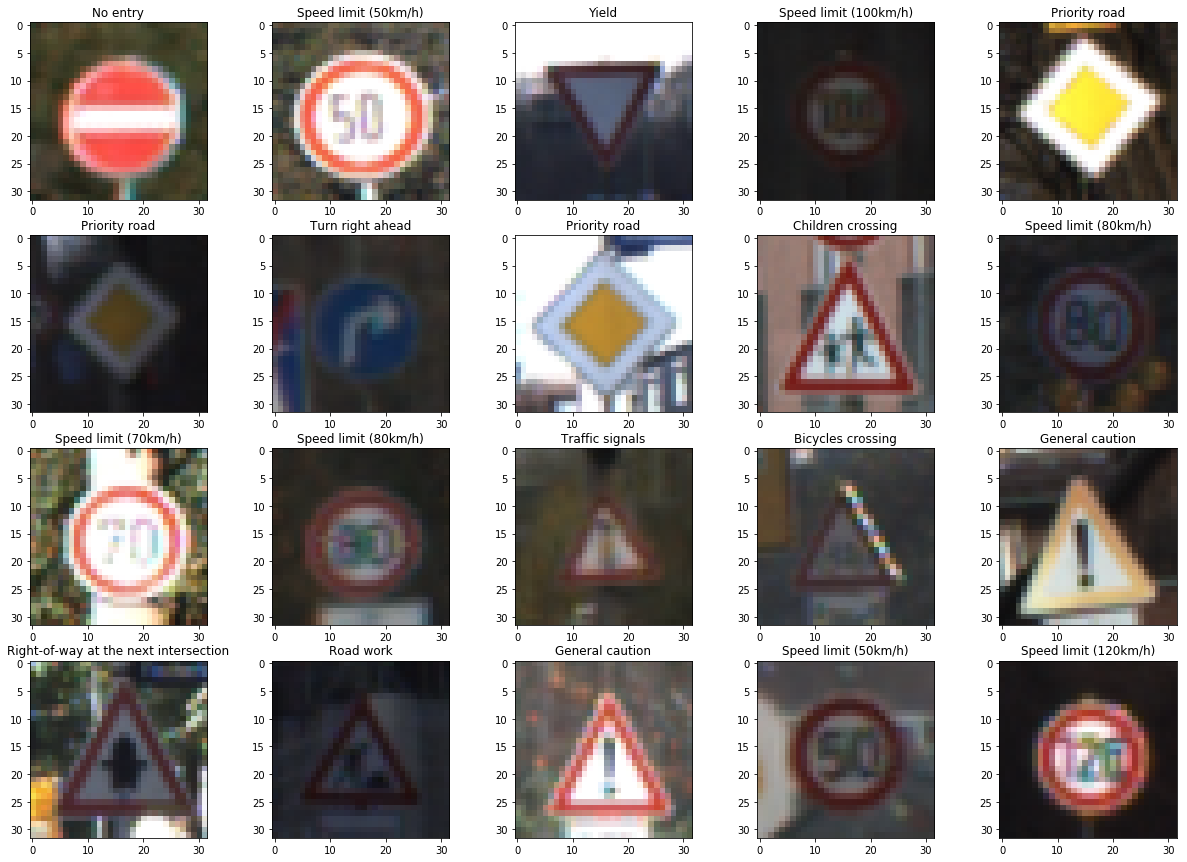

In [4]:
show_random_sample(X_train, y_train)

{0: 180, 1: 1980, 2: 2010, 3: 1260, 4: 1770, 5: 1650, 6: 360, 7: 1290, 8: 1260, 9: 1320, 10: 1800, 11: 1170, 12: 1890, 13: 1920, 14: 690, 15: 540, 16: 360, 17: 990, 18: 1080, 19: 180, 20: 300, 21: 270, 22: 330, 23: 450, 24: 240, 25: 1350, 26: 540, 27: 210, 28: 480, 29: 240, 30: 390, 31: 690, 32: 210, 33: 599, 34: 360, 35: 1080, 36: 330, 37: 180, 38: 1860, 39: 270, 40: 300, 41: 210, 42: 210}


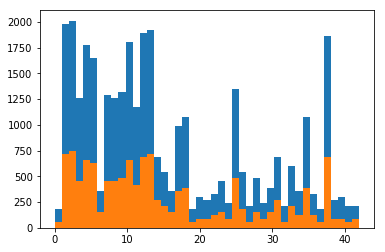

In [5]:
plt.hist(y_train, bins = np.unique(y_train).size)
plt.hist(y_test, bins = np.unique(y_test).size)

unique_train, counts_train = np.unique(y_train, return_counts=True)
class_counts_train = dict(zip(unique_train, counts_train))
print(class_counts_train)

It appears the distributions of classes is not even.  I will address this in the data augementation section.

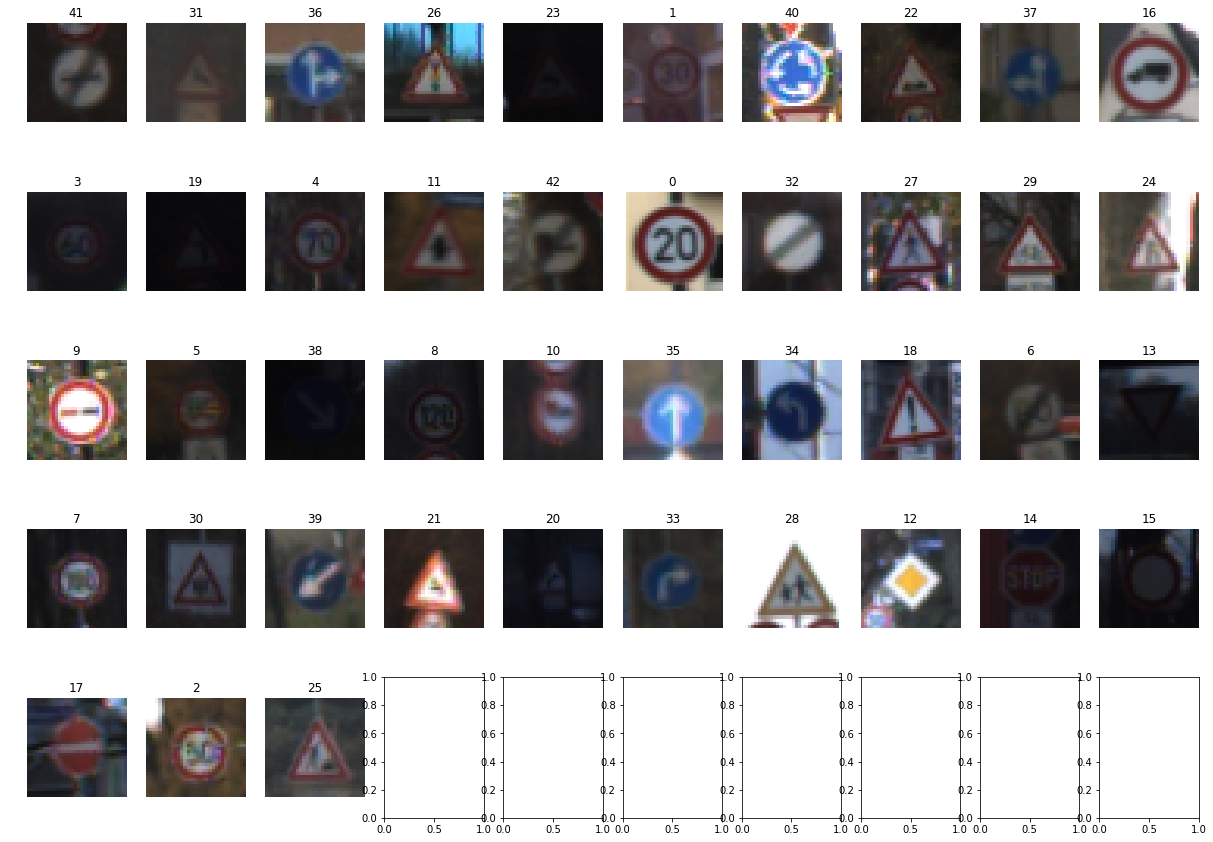

In [6]:
#View an example of each different type of class:

rows, columns = 5,10
fig, axis = plt.subplots(rows, columns, figsize=(21, 15))
axis = axis.ravel()
unique_classes_found = []
unique_classes_displayed = []
k=0
for i in range(rows*columns):
    for j in range(len(X_train)):
        k=j
        if y_train[k] not in unique_classes_found:
            unique_classes_found.append(y_train[k])
            break
            
    if y_train[k] not in unique_classes_displayed:
        image = X_train[k]
        axis[i].axis('off')
        axis[i].imshow(image)
        image_class = y_train[k]
        axis[i].set_title(image_class)
        unique_classes_displayed.append(y_train[k])

Some classes are symmetric or can be mapped to another type of class by mirroring the image.  This will help in augmenting the data

In [7]:
sym_y = [26,22,11,35,18,13,30]
sym_x = [1,9,5]
sym_xy = [32,12,15,17]
mappable = {19:20,33:34,36:37,38:39,20:19,34:33,37:36,39:38}

----

## Part 2: Design and Test a Model Architecture

Design and implementation of a deep learning model that learns to recognize traffic signs. The model will be trained and tested on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation will be used as a starting point. Preprocessing will be used to properly prepare the data to be fed into the neural network.

Aspects considered while designing the network:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf).

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Various preprocessing steps are defined below.

In [8]:
import cv2
from skimage import data, exposure, img_as_float

class PreProcessor:
    
    def rgb_to_yuv(self, image_dataset):
        internal_dataset = np.copy(image_dataset)
        return np.array([cv2.cvtColor(image, cv2.COLOR_RGB2YUV) for image in internal_dataset])
    
    def rgb_to_grayscale(self, image_dataset):
        internal_dataset = np.copy(image_dataset)
        return np.dot(internal_dataset[...,:3], [0.299, 0.587, 0.114])
    
    def normalize(self, image_dataset):
        internal_dataset = np.copy(image_dataset)
        return internal_dataset/128 - 1
    
    #This takes a long time to process!!!
    def enhanced_grayscale(self, image_dataset):
        internal_dataset = self.rgb_to_grayscale(np.copy(image_dataset))
        for i in range(len(internal_dataset)):
            internal_dataset[i] = exposure.equalize_adapthist(internal_dataset[i]/255.)
        internal_dataset = internal_dataset.reshape(internal_dataset.shape + (1,)) 
        return internal_dataset
    
pp = PreProcessor()

In [9]:
#The skimage exposure processing appeared to work the best for maximum accuracy.

X_train_processed = pp.enhanced_grayscale(X_train)
X_valid_processed = pp.enhanced_grayscale(X_valid)
X_test_processed = pp.enhanced_grayscale(X_test)

C:\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


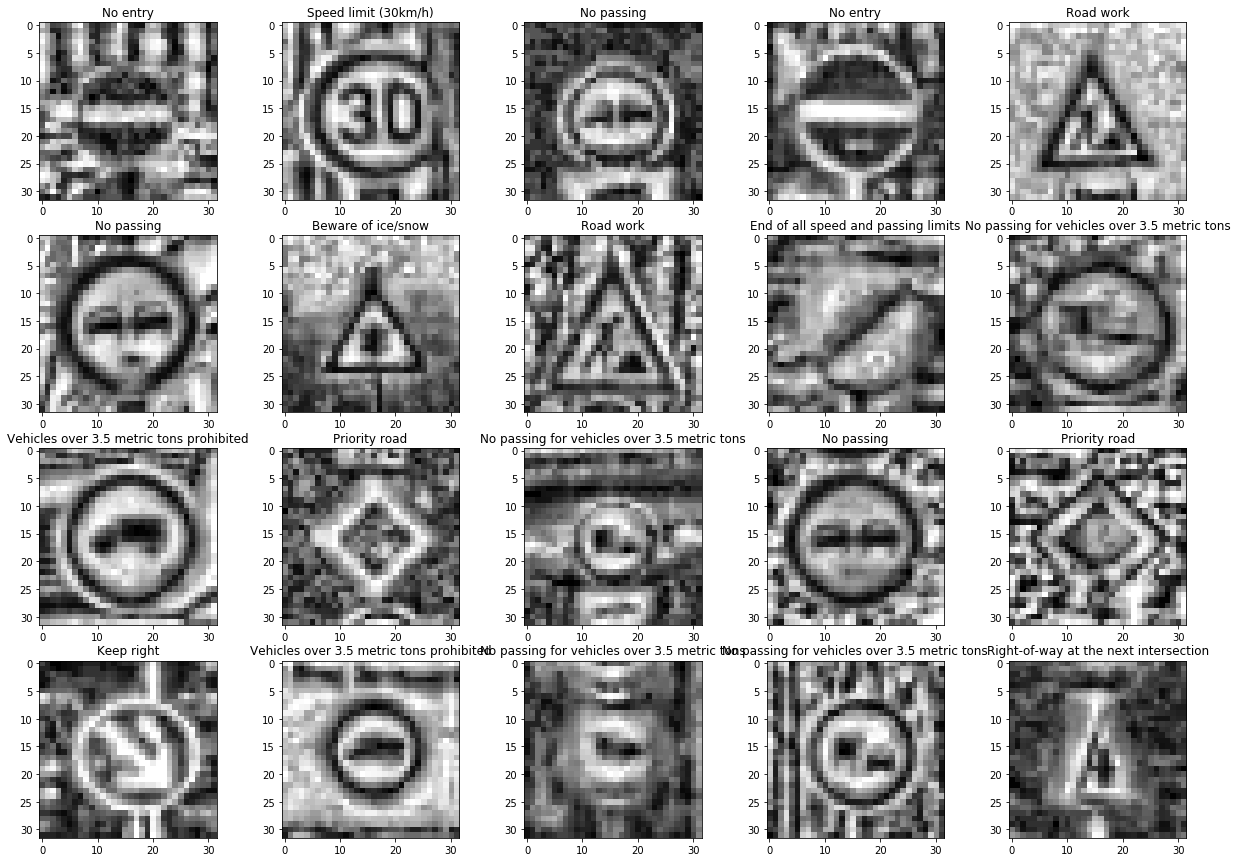

In [10]:
show_random_sample(X_train_processed, y_train)

### Data Augmentation

The amount of classes is not evenly distributed.  The process below will increase the classes by creating fake data from existing data. 

In [11]:
#Data set augmentation
from skimage.transform import rotate
from skimage.transform import warp
from skimage.transform import ProjectiveTransform

class Augmenter:
    
    def get_all_of_one_class(self, class_number, dataset_y):
        i=0
        positions = []
        for y in dataset_y:
            if y == class_number:
                positions.append(i)
            i += 1
        return positions
    
    def warp_image(self, image, factor):
        internal_image = np.copy(image)
        size = internal_image.shape[0]
        x = size * factor
        def get_rnd():
            return random.uniform(-x, x)
        transform = ProjectiveTransform()
        transform.estimate(np.array(((get_rnd(), get_rnd()), (get_rnd(), size - get_rnd()), (size - get_rnd(), size - get_rnd()),
                                     (size - get_rnd(), get_rnd()))), np.array(((0, 0),(0, size),(size, size),(size, 0))))
        internal_image = warp(internal_image, transform, output_shape=(size, size), order = 1, mode = 'edge')
        return internal_image
    
    def rotate_image(self, image, factor):
        internal_image = np.copy(image)
        theta = 34. * factor
        rotate(internal_image, random.uniform(-theta, theta), mode = 'edge')
        return internal_image  
    
    def flip_x(self, image):
        internal_image = np.copy(image)
        return cv2.flip(internal_image, 0)
    
    def flip_y(self, image):
        internal_image = np.copy(image)
        return cv2.flip(internal_image, 1)  
    
    def generate_new_images(self, sample_set, amount, class_number, dataset_x=None, dataset_y=None, mappable=None):
        new_images = []
        options = [1,2,3,4,5] #[warp, rotate, flip horizontally, flip vertically, map]
        for i in range(amount):
            option = None
            while(option is None):
                pick = random.choice(options)
                if pick == 1 or pick == 2:
                    option=pick
                elif pick == 3 and (class_number in sym_y or class_number in sym_xy):
                    option=pick
                elif pick == 4 and (class_number in sym_x or class_number in sym_xy):
                    option=pick
                elif pick == 5 and dataset_x is not None and dataset_y is not None and mappable is not None:
                    if class_number in mappable:
                        option=pick
            new_image = None
            if pick == 1:
                new_images.append(self.warp_image(random.choice(sample_set), 0.13))
            elif pick == 2:
                new_images.append(self.rotate_image(random.choice(sample_set), 0.13))
            elif pick == 3:
                new_image = self.flip_x(random.choice(sample_set))
                if(len(new_image.shape) < 3):
                    new_image = new_image.reshape(new_image.shape + (1,))
                new_images.append(new_image)
            elif pick == 4:
                new_image = self.flip_y(random.choice(sample_set))
                if(len(new_image.shape) < 3):
                    new_image = new_image.reshape(new_image.shape + (1,))
                new_images.append(new_image) 
            elif pick == 5:
                mappable_class = mappable[class_number]
                j=0
                mappable_positions = []
                for y in dataset_y:
                    if y == class_number:
                        mappable_positions.append(i)
                    j += 1
                new_image = self.flip_y(dataset_x[random.choice(mappable_positions)])
                if(len(new_image.shape) < 3):
                    new_image = new_image.reshape(new_image.shape + (1,))
                new_images.append(new_image)
                    
        return np.asarray(new_images)
    
    def fill_where_missing(self, dataset_x, dataset_y, method="mean", mappable=None):
        internal_dataset_x = np.copy(dataset_x)
        internal_dataset_y = np.copy(dataset_y)
        class_set = np.unique(internal_dataset_y)
        new_images_x = None
        new_images_y = []        
        
        if method == "mean":
            unique, counts = np.unique(y_train, return_counts=True)
            average = np.mean(counts)
            for c in class_set:
                sample_set = []
                i = 0
                for x in internal_dataset_y:
                    if x == c: 
                        sample_set.append(internal_dataset_x[i])
                    i += 1
                amount = int(average - class_counts_train[c])
                if amount > 0:
                    new_images_x = self.generate_new_images(np.asarray(sample_set), amount, c, dataset_x, dataset_y, mappable)
                    internal_dataset_x = np.append(internal_dataset_x, new_images_x, axis=0)
                    internal_dataset_y = np.append(internal_dataset_y,np.full((amount,),c),axis=0)
                    new_images_y = np.append(new_images_y,np.full((amount,),c),axis=0)
        elif method == "max":
            unique, counts = np.unique(y_train, return_counts=True)
            maximum = np.amax(counts)
            for c in class_set:
                sample_set = []
                i = 0
                for x in internal_dataset_y:
                    if x == c: 
                        sample_set.append(internal_dataset_x[i])
                    i += 1
                amount = int(maximum - class_counts_train[c])
                if amount > 0:
                    new_images_x = self.generate_new_images(np.asarray(sample_set), amount, c, dataset_x, dataset_y, mappable)
                    internal_dataset_x = np.append(internal_dataset_x, new_images_x, axis=0)
                    internal_dataset_y = np.append(internal_dataset_y,np.full((amount,),c),axis=0)
                    new_images_y = np.append(new_images_y,np.full((amount,),c),axis=0)
        elif method == "random":
            unique, counts = np.unique(y_train, return_counts=True)
            maximum = np.amax(counts)
            average = np.average(counts)
            for c in class_set:
                sample_set = []
                i = 0
                for x in internal_dataset_y:
                    if x == c: 
                        sample_set.append(internal_dataset_x[i])
                    i += 1
                amount = int(random.uniform(int(average), maximum)) - class_counts_train[c]
                if amount > 0:
                    new_images_x = self.generate_new_images(np.asarray(sample_set), amount, c, dataset_x, dataset_y, mappable)
                    internal_dataset_x = np.append(internal_dataset_x, new_images_x, axis=0)
                    internal_dataset_y = np.append(internal_dataset_y,np.full((amount,),c),axis=0)
                    new_images_y = np.append(new_images_y,np.full((amount,),c),axis=0)
        print("Added {} new features!".format(len(internal_dataset_y) - len(dataset_y)))
        return internal_dataset_x, internal_dataset_y, new_images_x, [int(i) for i in new_images_y]
    
augmenter = Augmenter()
    

In [12]:
#Randomly increase sparse classes

X_train_augmented, y_train_augmented, new_images_x, new_images_y = augmenter.fill_where_missing(X_train_processed, y_train, method="random", mappable=mappable)

Added 29280 new features!


In [13]:
#See how many new classes:

print("X_train_augmented size: {}".format(X_train_augmented.shape))
print("y_train_augmented size: ({})".format(len(y_train_augmented)))

X_train_augmented size: (64079, 32, 32, 1)
y_train_augmented size: (64079)


(array([ 1717.,  1984.,  2010.,  1260.,  1947.,  1650.,  1963.,  1290.,
         1260.,  1320.,  1800.,  1170.,  1890.,  1920.,  1462.,  1092.,
         1375.,  1537.,  1175.,  1432.,  1553.,  1914.,  1028.,  2000.,
          901.,  1897.,  1201.,  1612.,  1423.,  1046.,  1479.,   977.,
         1430.,  1837.,  1975.,  1152.,  1985.,  1760.,  1860.,   962.,
          901.,  1096.,   836.]),
 array([  0.        ,   0.97674419,   1.95348837,   2.93023256,
          3.90697674,   4.88372093,   5.86046512,   6.8372093 ,
          7.81395349,   8.79069767,   9.76744186,  10.74418605,
         11.72093023,  12.69767442,  13.6744186 ,  14.65116279,
         15.62790698,  16.60465116,  17.58139535,  18.55813953,
         19.53488372,  20.51162791,  21.48837209,  22.46511628,
         23.44186047,  24.41860465,  25.39534884,  26.37209302,
         27.34883721,  28.3255814 ,  29.30232558,  30.27906977,
         31.25581395,  32.23255814,  33.20930233,  34.18604651,
         35.1627907 ,  36.1395

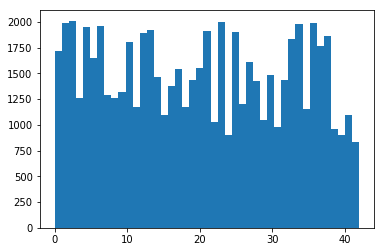

In [14]:
#Visualize the new data on histogram plot

plt.hist(y_train_augmented, bins = np.unique(y_train_augmented).size)

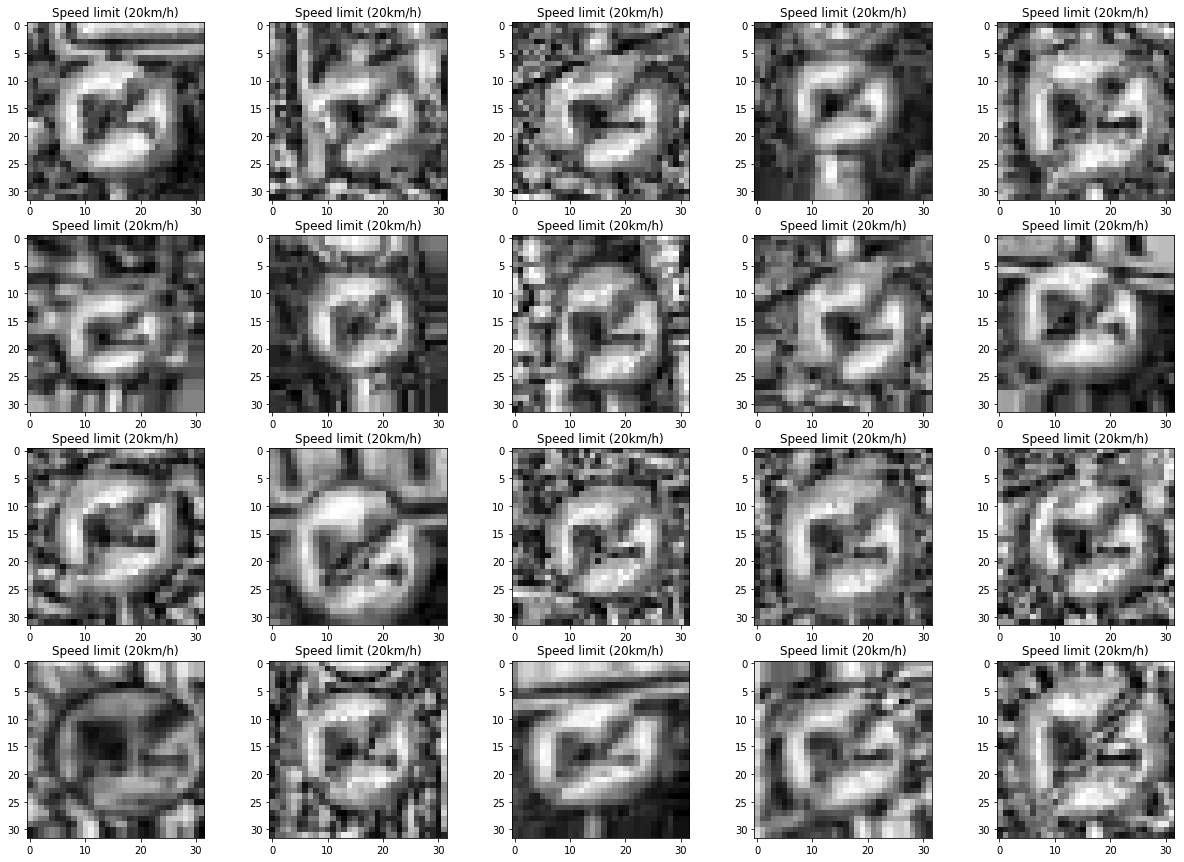

In [15]:
#Show newly created data:

show_random_sample(new_images_x, new_images_y)

### Model Architecture

In [16]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle

input_depth = X_train_augmented.shape[3]

In [17]:
conv1 = None
conv2 = None
fc1 = None
fc2 = None

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    global conv1_act, conv2_act
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, input_depth, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.bias_add(tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID'), conv1_b)

    # Activation.
    conv1_act = conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.avg_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.bias_add(tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID'), conv2_b)
    
    # Activation.
    conv2_act = conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.avg_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.nn.bias_add(tf.matmul(fc0, fc1_W), fc1_b)
    
    # Activation.
    fc1    = tf.nn.relu(fc1)
    
    # Apply dropout
    fc1    = tf.nn.dropout(fc1, keep_prob)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.nn.bias_add(tf.matmul(fc1, fc2_W), fc2_b)
    
    # Activation.
    fc2    = tf.nn.relu(fc2)
    
    # Apply dropout
    fc2    = tf.nn.dropout(fc2, keep_prob)

    # Layer 5: Fully Connected. Input = 84. Output = n_classes (43).
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.nn.bias_add(tf.matmul(fc2, fc3_W), fc3_b)
    
    return logits

In [18]:
x = tf.placeholder(tf.float32, (None, 32, 32, input_depth))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

keep_prob = tf.placeholder(tf.float32)

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [19]:
EPOCHS = 55
BATCH_SIZE = 144

rate = 0.001

validation_accuracy_array = []

logits = LeNet(x)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [20]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

In [21]:
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [22]:
#Traning the model:

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train_shuffled, y_train_shuffled = shuffle(X_train_augmented, y_train_augmented)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_shuffled[offset:end], y_train_shuffled[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
        
        
        
        validation_accuracy = evaluate(X_valid_processed, y_valid)
        validation_accuracy_array.append(validation_accuracy)
        
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        saver.save(sess, "./model/LeNet.ckpt")
        print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.522

Model saved
EPOCH 2 ...
Validation Accuracy = 0.656

Model saved
EPOCH 3 ...
Validation Accuracy = 0.732

Model saved
EPOCH 4 ...
Validation Accuracy = 0.784

Model saved
EPOCH 5 ...
Validation Accuracy = 0.814

Model saved
EPOCH 6 ...
Validation Accuracy = 0.836

Model saved
EPOCH 7 ...
Validation Accuracy = 0.844

Model saved
EPOCH 8 ...
Validation Accuracy = 0.860

Model saved
EPOCH 9 ...
Validation Accuracy = 0.869

Model saved
EPOCH 10 ...
Validation Accuracy = 0.880

Model saved
EPOCH 11 ...
Validation Accuracy = 0.889

Model saved
EPOCH 12 ...
Validation Accuracy = 0.884

Model saved
EPOCH 13 ...
Validation Accuracy = 0.899

Model saved
EPOCH 14 ...
Validation Accuracy = 0.906

Model saved
EPOCH 15 ...
Validation Accuracy = 0.904

Model saved
EPOCH 16 ...
Validation Accuracy = 0.908

Model saved
EPOCH 17 ...
Validation Accuracy = 0.911

Model saved
EPOCH 18 ...
Validation Accuracy = 0.909

Model saved
EPOCH 19 ...
Validation 

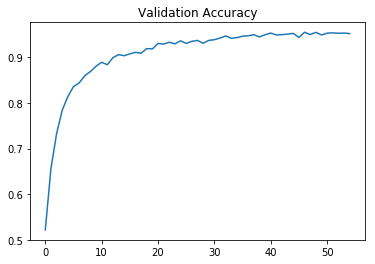

In [23]:
plt.plot(validation_accuracy_array)
plt.title("Validation Accuracy")
plt.show()

In [24]:
print("Best Validation Accuracy = {:.3f}".format(max(validation_accuracy_array)))

Best Validation Accuracy = 0.955


In [25]:
with tf.Session() as sess:
    saver.restore(sess, "./model/LeNet.ckpt")
    
    test_accuracy = evaluate(X_test_processed, y_test)

    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./model/LeNet.ckpt
Test Accuracy = 0.940


---

## Step 3: Test a Model on New Images

To give more insight into how the model is working, pictures of German traffic signs were downloaded from the web.

### Load and Output the Images

In [26]:
import glob
import numpy as np
import matplotlib.pyplot as plt

directory = 'dataset/test/*.jpg'

X_new = [plt.imread(path) for path in glob.glob(directory)]
y_new = np.asarray([12,13,14,17,35,36])

In [27]:
X_new_processed = pp.enhanced_grayscale(X_new)

C:\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


### Predict the Sign Type for Each Image

In [28]:
new_test_accuracy = 0

with tf.Session() as sess:
    saver.restore(sess, "./model/LeNet.ckpt")
    
    new_test_accuracy = evaluate(X_new_processed, y_new)

INFO:tensorflow:Restoring parameters from ./model/LeNet.ckpt


### Analyze Performance

In [29]:
print("New Test Accuracy = {:.3f}".format(new_test_accuracy))

New Test Accuracy = 0.833


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [30]:
with tf.Session() as sess:
    saver.restore(sess, "./model/LeNet.ckpt")
    softmax_prob = sess.run(tf.nn.softmax(logits), feed_dict={x: X_new_processed, keep_prob: 0.5})
    top_5=sess.run(tf.nn.top_k(softmax_prob, k=5))

INFO:tensorflow:Restoring parameters from ./model/LeNet.ckpt


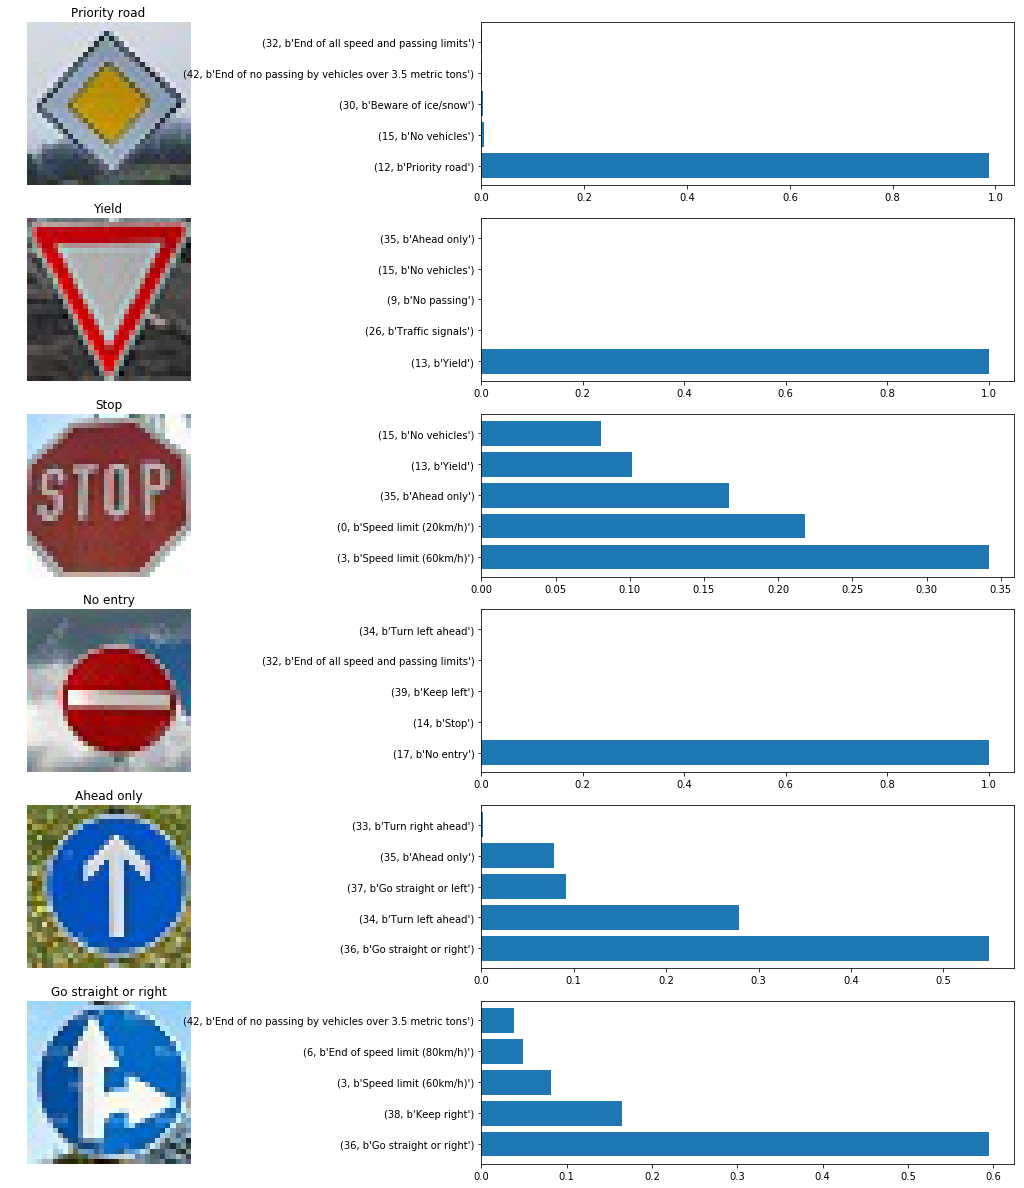

In [31]:
plt.figure(figsize=(21, 21))
for i in range(len(X_new)):
    plt.subplot(len(X_new), 2, 2*i+1)
    plt.imshow(X_new[i]) 
    plt.title(sign_names[y_new[i]][1].decode('ascii'))
    plt.axis('off')
    plt.subplot(len(X_new), 2, 2*i+2)
    plt.barh(np.arange(1, 6, 1), top_5.values[i, :])
    labels=[sign_names[j] for j in top_5.indices[i]]
    plt.yticks(np.arange(1, 6, 1), labels)
plt.show()

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [32]:
# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")
    plt.show()

Loading model...
INFO:tensorflow:Restoring parameters from ./model/LeNet.ckpt
Model loaded.

(41, b'End of no passing')


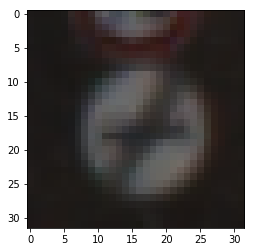

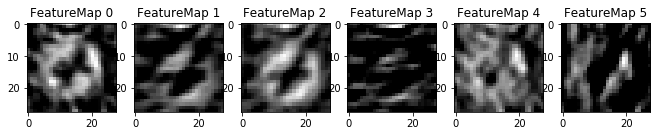

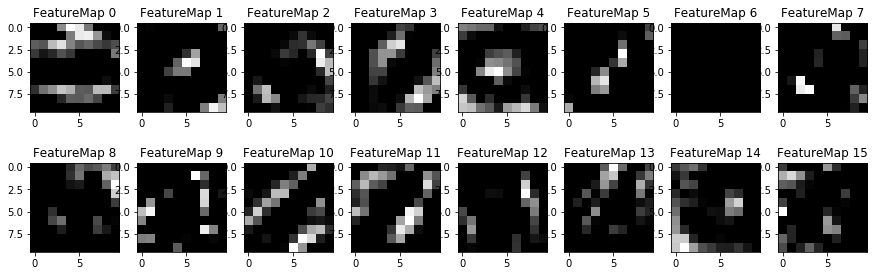

In [33]:
print("Loading model...")
with tf.Session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess, "./model/LeNet.ckpt")
    print("Model loaded.")

    print()
    print(sign_names[y_train[0]])
    plt.imshow(X_train[0], cmap='gray', vmin=-1, vmax=1)
    plt.show()
    img = np.expand_dims(X_train_processed[0], axis=0)
    outputFeatureMap(img, conv1_act)
    outputFeatureMap(img, conv2_act)